## Análise Exploratória *50K IMDB Reviews* Dataset
Neste notebook vamos ler um arquivo do tipo **.csv** com cerca de 50.000 reviews de diversos filmes do [IMDB](https://www.imdb.com/) disponíveis no [Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) e realizar uma análise explarotária a fim de descobrir métricas e observações importantes.

O processo foi dividido em 4 etapas, sendo elas:

1. *Configuração de Ambiente*
   1. *Importações*
   2. *Métodos Comuns*
2. *Leitura do Dataset.*
   1. *Limpeza dos Diretórios*
   2. *Criação de arquivos de review*
3. *Nuvem de Palavras.*
4. *Distribuição de Tokens*

---

#### 1. Configuração de Ambiente
Instalação de bibliotecas necessárias e métodos base para o notebook.

In [ ]:
%pip install -r exploratory_analysis_req.txt

#### 1.1 Importações
Importando as bibliotecas necessárias para este notebook.

In [ ]:
import os
import pandas as pds
import seaborn as sns
import matplotlib as mpl
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from wordcloud import WordCloud, ImageColorGenerator
from nltk import FreqDist, RegexpTokenizer
from nltk.corpus import brown, stopwords
from bs4 import BeautifulSoup


In [ ]:
# lendo o csv usando a biblioteca pandas
data_frame = pds.read_csv('../assets/Reviews/reviews.csv')
# define palavras padrao a serem procuradas ao longo do csv
pattern = r'(<br>|<br />|http)'
# remove as palavras padrao por string vazia
data_frame['review'] = data_frame['review'].str.replace(pattern, "", regex=True)

#### 1.2 Métodos Comuns

Métodos utilizados nas demais células deste notebook, posicionados desde o início para melhor manutenção do código.

In [ ]:
# Métodos Comuns

# Adquire e retorna a frequencias de palavras a partir de um 
# filepath e dicionario como parametros.
def get_top_words(data: dict, filepath: str):
    with open(filepath, 'r', encoding='utf-8') as file:
        
        review = file.read()
        tokenizer = RegexpTokenizer(r'\w+')
        words = tokenizer.tokenize(review)
        stop_words = stopwords.words('english')
        filtered_words = [item for item in words if item not in stop_words]
    
        for item in FreqDist(filtered_words).most_common():
            key = item[0]
            value = item[1]

            if (key in data): data[key] += value
            else:  data[key] = value

        return data
    
# gera uma nuvem de palavras a partir da lista de frequencias
# e titulo do grafico fornecidos como parametro.
def get_word_cloud(title: str, limit: int, data: dict):
    cloud = WordCloud(
        max_words=limit,
        colormap='tab20c',
        stopwords=stopwords,
        collocations=True
    ).generate_from_frequencies(data)

    plt.figure(figsize=(10,8))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(title, fontsize=12)
    plt.show() 

# gera um gráfico de rosca a partir dos valores, etiquetas, titulo
# e titulo da legenda
def get_donut_chart(title, legend_title, data, labels):
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

    def labelFmt(pct, vals):
        absolute = int(np.round(pct/100.*np.sum(vals)))
        return f"{pct:.0f}%"

    wedges, texts, autotexts = ax.pie(
        data, 
        autopct=lambda pct: labelFmt(pct, data),
        textprops=dict(color="w")
    )

    ax.legend(
        wedges, 
        labels,
        ncol=3,
        title=legend_title,
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1)
    )

    plt.setp(autotexts, size=8, weight="bold")
    ax.set_title(title)
    plt.show()


# retorna um array contendo todo o conteudo de um arquivo .txt
# livre das stop words fornecidas pela biblioteca NLTK de acordo
# com o caminho do arquivo parametrizado e seguindo o formato de 
# token. Retorna excecao caso o diretorio ou arquivo nao exista.
def get_dir_content(dirpath: str):
    try:
        # acumula palavras
        filtered_words = []
        if (os.path.isdir(dirpath)):
            for path in os.listdir(dirpath):
                filepath = os.path.join(dirpath, path)
                with open(filepath, 'r', encoding='utf-8') as file:
                    review = file.read()
                    # transformando apenas palavras em token, sem pontuação
                    tokenizer = RegexpTokenizer(r'\w+')
                    words = tokenizer.tokenize(review)
                    # adquirindo stop words
                    stop_words = stopwords.words('english')
                    # removendo stop words
                    filtered_words += [word for word in words if word not in stop_words]
        return filtered_words
    except Exception as err:
        print("O caminho para o arquivo fornecido não é válido, erro: ", err)



#### 2. Leitura do Dataset.
O objetivo deste passo é ler o CSV referente aos reviews do IMDB e verificar se o sentimento foi positivo ou negativo (lembrando que neste Dataset só existem esses dois sentimentos), em seguida vamos gerar um arquivo **.txt** no padrão *indíce_linha-sentimento.txt* e enviar para um diretório especifico com base no sentimento do review (positivo ou negativo).


#### 2.1. Limpeza dos Diretórios
Remoção de todo e qualquer dado presente nos diretórios **../dist/reviews/positivos** e **../dist/reviews/negativos**.

In [ ]:
# Antes realizaremos a limpeza dos diretorios antes de começarmos a criar 
# os arquivos .txt
path_positivos = "../dist/reviews/positivos"
path_negativos = "../dist/reviews/negativos"

# começamos com as palavras de sentimento positivo
diretorios = [path_positivos, path_negativos]

try:
	# primeiro nos certificamos de que os diretórios existem
	if(os.path.isdir(path_negativos)):
		# verificamos cada arquivo do dentro do diretorio
		for file in os.listdir(path_negativos):
			# ignoramos arquivos diferentes do tipo .txt
			if not file.endswith(".txt"):
				continue
			os.remove(os.path.join(path_negativos, file)) #removemos o arquivo
	
	# repetimos o processo para o path_positivos	
	if (os.path.isdir(path_positivos)): 	
		for file in os.listdir(path_positivos):
			if not file.endswith(".txt"):
				continue
			os.remove(os.path.join(path_positivos, file))

except Exception as err:
    print("Erro ao limpar diretorios:\n{0}".format(err))

#### 2.2. Criação dos Arquivos de Review
Criação de arquivos **.txt** para cada review, em seguida a inserção dos mesmos em seus respectivos diretórios.

In [ ]:
#primeiro lemos o CSV usando a biblioteca pandas para facilitar futuros passos
df_reviews = pds.read_csv('../assets/Reviews/reviews.csv')
# definimos um padrao para buscarmos e removermos dentro do csv, removendo tags
# de HTML que ficaram nos reviews durante o processo.
pattern = r'(<br>|<br />|http)'
df_reviews['review'] = df_reviews['review'].str.replace(pattern, "", regex=True)

# em seguida percorremos cada dataframe para criarmos e escrevermos os arquivos .txt
for i in df_reviews.index:
 	#deixamos todo o review em lower case para melhor interpretação
	review = df_reviews['review'][i].lower()
	sentiment = df_reviews['sentiment'][i]

	path_atual = path_positivos if (sentiment == 'positive') else path_negativos

	filename = "{path}/{index}-{sentiment}.txt".format(
		index=i,
		path=path_atual, 
		sentiment=sentiment
	)
		
	with open(filename, 'w', encoding='utf-8') as file:
		file.writelines(review)


#### 3. Nuvem de Palavras
Implementação de duas *word clouds* com a frequencia das 100 palavras mais faladas nas reviews.

In [ ]:
freq_positivos = {}
freq_negativos = {}

for path in diretorios:
    aux_freq = {} # so é necessário resetar esta variavel ao trocarmos de diretorio 

    for filename in os.listdir(path):
        filepath = os.path.join(path, filename)
        aux_freq = get_top_words(aux_freq, filepath)

    # verificamos o caso atual, seja positivo ou negativo
    if 'positivos' in path: freq_positivos = aux_freq
    else: freq_negativos = aux_freq     

# nuvem de palavras com as 100 palavras mais repetidas durante 
# os reviews classificados como positivos
stop_words = stopwords.words('english')

for word in stop_words:
    freq_positivos.pop(word, None)
    freq_negativos.pop(word, None)

get_word_cloud("Top 100 Palavras (Positivas)", 100, freq_positivos)
get_word_cloud("Top 100 Palavras (Negativas)", 100, freq_negativos)

### 4. Distribuição de Tokens.
Implementação de dois *pie charts* com a porcentagem de tokens distribuídos pelo tamanho de cada token.

In [ ]:
# método para remover toda tupla de um dicionario cujo valor 
# seja menor que o parametro least
def remove_least(tokens: dict, least: int):
    return {key: value for key, value in tokens.items() if value > least}

# método que contabiliza quantidade de tokens por tamanho
def count_labels(data: list[str]):
    response = {}

    for token in data:
        size = len(token)
        if (size in response.keys()): response[size] += 1  
        else: response[size] = 1
    
    return response

# arrays para agrupamento dos tokens
positive_tokens = []
negative_tokens = []

for dirpath in diretorios:
    # buscamos os tokens de todos os arquivos de um diretorio
    tokens = get_dir_content(dirpath)
    # verifica em qual array iremos inserir os tokens
    if ('positivos' in dirpath): positive_tokens += tokens 
    else: negative_tokens += tokens 

# contabilizamos incidencia de tokens negativos/positivos
positive_tokens_len = count_labels(positive_tokens) 
negative_tokens_len = count_labels(negative_tokens)

# calculamos a soma das incidencias de cada token
total_positive_tokens = sum(positive_tokens_len.values(), 0.0)
total_negative_tokens = sum(negative_tokens_len.values(), 0.0)

# removemos alguns dos tokens com incidencia menor que 2% por
# da legibilidade dos graficos de fatia (pie charts)
least = 0.02 # valor minimo para remover tokens com baixa incidencia
positive_tokens_len = remove_least(positive_tokens_len, (least * total_positive_tokens))
negative_tokens_len = remove_least(negative_tokens_len, (least * total_negative_tokens))

# transformando os valores brutos em porcentagem ao dividir pelo total
# dos tokens positivos e negativos
positive_percents = {k: v / total_positive_tokens for k, v in positive_tokens_len.items()}
negative_percents = {k: v / total_negative_tokens for k, v in negative_tokens_len.items()}

# Gráfico com valores positivos
positive_data = list(positive_percents.values());
positive_labels = list(positive_percents.keys());
get_donut_chart(
    "Dist. de Tokens Positivos (maiores que 2%)", 
    "Tamanho do Token", 
    positive_data, 
    positive_labels
)
# Gráfico com valores negativos
negative_data = list(negative_percents.values());
negative_labels = list(negative_percents.keys());
get_donut_chart(
    "Dist. de Tokens Negativos (maiores que 2%)", 
    "Tamanho do Token", 
    negative_data, 
    negative_labels
)


### 5. Tamanho das Críticas.
Implementação de dois *bar charts* com o tamanho de cada crítica e a média delas.

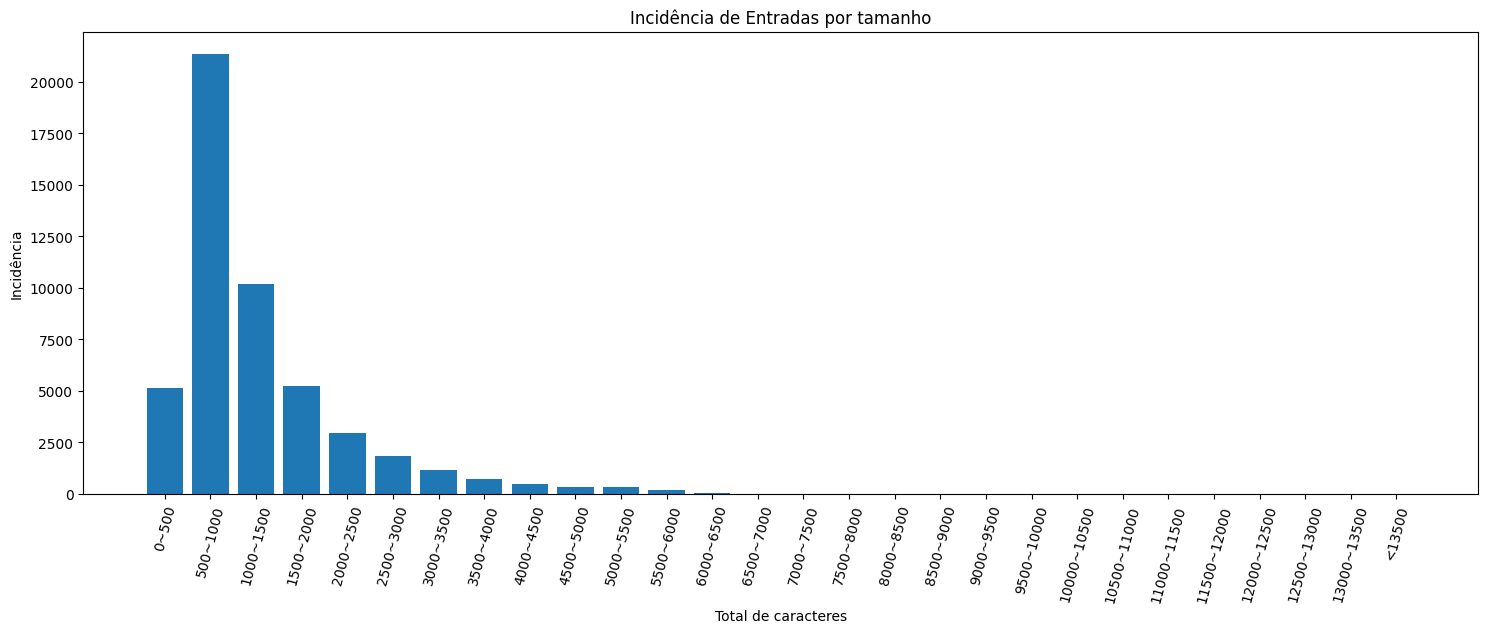

In [67]:
def sumInRange(values: dict, least: int, most: int):
    response = 0

    for key, value in values.items(): 
        if (least <= key < most): response += value

    return response


size_freq = {}

for dirpath in diretorios:
    # buscamos as criticas de todos os arquivos de um diretorio
    for path in os.listdir(dirpath):
        # abrimos o arquivo .txt
        filepath = os.path.join(dirpath, path)

        with open(filepath, 'r', encoding='utf-8') as file:
            total_chars = len(file.readline())

            if (total_chars in size_freq): size_freq[total_chars] += 1
            else: size_freq[total_chars] = 1

# contando o total de arquivos lidos
total_readed_files = sum(size_freq.values())

entry_sizes = size_freq.keys()

classes = {}
group_factor = 500
max_entry = max(entry_sizes)

# agrupando em classes intercaladas por 500 unidades para melhor visualizacao
for index in range(0, max_entry):
    if (index % group_factor == 0): classes[index] = 0

size = len(classes.keys())

classes_as_list = list(classes.keys())
keys = list(size_freq.keys())
values = list(size_freq.values())

chart_data = {}

index = 0
for item in classes_as_list:

    current = int(item)
    if (index == size-1): 
        next = np.Infinity
        range_as_str = "<{0}".format(current)
    else:
        next = int(classes_as_list[index + 1])
        range_as_str = "{0}~{1}".format(current, next) 

    chart_data[range_as_str] = sumInRange(size_freq, current, next)
                
    if (index != size - 1): index+=1
    else: break

bar_width = 1

fig, ax = plt.subplots(figsize=(18,6))


values = list(chart_data.values())
categories = list(chart_data.keys())

ax.bar(categories, values, label=categories, color='tab:blue')

ax.set_ylabel('Incidência')
ax.set_xlabel('Total de caracteres')
ax.set_title('Incidência de Entradas por tamanho')
ax.tick_params(axis='x', rotation=65)

fig.align_xlabels()
plt.show()
